In [50]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error


In [51]:
 #set the size of our plots as they are a little small by default.
plt.rcParams["figure.figsize"] = (20,5)

In [ ]:
import os

#mac path
mac_file_path = r'/Users/nathanstuttard/Portfolio/Collision_trips_ML_Project/Predicting-car-insurance-cost-throughcollision-risk-through-machine-learning-/Data/LBD_New_York_collisions_and_weather_data.csv'

#windows path
Ubuntu_file_path = r'/home/user/Data Science Projects/Taxi/Predicting-car-insurance-cost-throughcollision-risk-through-machine-learning-/Data/LBD_New_York_collisions_and_weather_data.csv'

# Check if the file exists
if os.path.exists(mac_file_path):
    df = pd.read_csv(mac_file_path)  # Read the CSV into a DataFrame
    print(df.head())  # Display the first few rows of the DataFrame
else:
    print("File not found.")


In [ ]:
df = df.sort_values(["year", "mo", "da"], ascending = (True, True, True)) # order the data by year, month, day in ascending order.
df.head() # check the data again by viewing the first 5 rows

In [ ]:
total_collisions = df['NUM_COLLISIONS'].sum()
print(type(total_collisions))
print("Total collisions before cleaning:", total_collisions)


Cleaning


In [ ]:
#original df
original_df = df

df_cleaned = df[(df["NUM_COLLISIONS"] > 350) & (df["NUM_COLLISIONS"] < 900)]
df_cleaned = df_cleaned.dropna(how='all')
df_cleaned.dropna(subset=['NUM_COLLISIONS'], inplace=True) 
df_cleaned['collision_date'] = pd.to_numeric(df['collision_date'], errors='coerce')  
total_collisions_post_clean = df_cleaned['NUM_COLLISIONS'].sum()
print("Total collisions before cleaning:", total_collisions)
print("Total total_collisions_post_clean:", total_collisions_post_clean)
difference = total_collisions - total_collisions_post_clean
print(f"Dropped {difference} rows")


Descriptive statistics

In [100]:
def collision_grouping_decorator(group_by):
    """Decorator to group collisions by day or month."""
    def wrapper(func):
        def inner(dataframe):
            collisions = dataframe.groupby(group_by)['NUM_COLLISIONS'].sum().reset_index()
            collisions.columns = ['Group', 'Total Collisions']
            return collisions.sort_values(by='Total Collisions', ascending=False)
        return inner
    return wrapper

@collision_grouping_decorator('day')
def group_collisions_by_day(dataframe):
    """Groups collisions by day of the week."""
    pass  # The actual logic is handled by the decorator

@collision_grouping_decorator('mo')
def group_collisions_by_month(dataframe):
    """Groups collisions by month."""
    pass  # The actual logic is handled by the decorator

# Get collisions grouped by day and month
collisions_per_day_df = group_collisions_by_day(df_cleaned)
collisions_per_month_df = group_collisions_by_month(df_cleaned)

# Print results
print("Collisions per Day:")
print(collisions_per_day_df)

print("\nCollisions per Month:")
print(collisions_per_month_df)


##Interesting - Friday as the most collisions, with Sunday the least - rush hour, commuting
## so what's the connection between Friday and Sunday. Sunday is a quieter day, Friday busier. Don't have a time of day so can't look at this in more detail.
##is there time data available?


#Correlation between weather? Rainfall on a particular day? or by month?

Collisions per Day:
   Group  Total Collisions
4      5            207693
3      4            196751
1      2            194514
2      3            194134
0      1            187203
5      6            175254
6      7            151724

Collisions per Month:
    Group  Total Collisions
5       6            118319
9      10            116505
4       5            116190
6       7            113076
8       9            111650
7       8            111309
10     11            109884
11     12            108360
2       3            106432
3       4            104204
0       1             99241
1       2             92103


In [57]:
#examine weather data etc



In [ ]:
# Grouping by 'year' and summing 'NUM_COLLISIONS' for each year
collisions_per_year = df_cleaned.groupby('year')['NUM_COLLISIONS'].sum()

# Convert the series to a DataFrame for plotting
collisions_per_year_df = collisions_per_year.reset_index()

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(collisions_per_year_df['year'], collisions_per_year_df['NUM_COLLISIONS'], color='skyblue')
plt.xlabel('Year')
plt.ylabel('Number of Collisions')
plt.title('Number of Collisions Per Year')
plt.xticks(collisions_per_year_df['year'])  # Ensure all years are displayed on the x-axis
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Narrative - ok clearly collisions are increasing, year on year

In [97]:
#Narrative - I am going to examine whether the number of collisions for each day of the week changes from year to year

# Define a mapping for days of the week
day_mapping = {1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday', 7: 'Sunday'}

# Apply the day mapping to the 'day' column
df_cleaned.loc[:, 'day_mapped'] = df_cleaned['day'].map(day_mapping)

# Group by year and day of the week, then sum the number of collisions
collisions_per_day_per_year = df_cleaned.groupby(['year', 'day_mapped'])['NUM_COLLISIONS'].sum().reset_index()

# Pivot the table to have years as rows and days of the week as columns
collisions_per_day_per_year_pivot = collisions_per_day_per_year.pivot_table(index='year', columns='day_mapped', values='NUM_COLLISIONS', fill_value=0)

# Display the resulting table
print(collisions_per_day_per_year_pivot)


day_mapped   Friday   Monday  Saturday   Sunday  Thursday  Tuesday  Wednesday
year                                                                         
2013        33109.0  29453.0   27702.0  24135.0   29726.0  30214.0    29138.0
2014        32415.0  29003.0   27658.0  22833.0   30473.0  29628.0    30586.0
2015        33146.0  31059.0   27978.0  24644.0   32906.0  32496.0    32403.0
2016        37147.0  32000.0   30794.0  26059.0   34682.0  34314.0    34235.0
2017        34948.0  32716.0   30640.0  27464.0   34445.0  33721.0    33856.0
2018        36928.0  32972.0   30482.0  26589.0   34519.0  34141.0    33916.0


Regression Analysis

In [60]:
df_2012 = df_cleaned[df_cleaned["year"] == 2012]
df_2012.loc[df_2012['day'] > 0, 'day'] = df_2012['day']+1 # change all days by adding 1.

df_2012.loc[df_2012['day'] == 8, 'day'] = 1 # change days that equal 8 to day 1

In [61]:
# Filter data for the year 2013
df_2013 = df_cleaned[df_cleaned["year"] == 2013].copy()

# Increment all days by 1
df_2013.loc[df_2013['day'] > 0, 'day'] += 1

# Change days that are equal to 8 to 1
df_2013.loc[df_2013['day'] == 8, 'day'] = 1

# Filter data for the year 2014
df_2014 = df_cleaned[df_cleaned["year"] == 2014].copy()

# Increment all days by 1
df_2014.loc[df_2014['day'] > 0, 'day'] += 1

# Change days that are equal to 8 to 1
df_2014.loc[df_2014['day'] == 8, 'day'] = 1

# Filter data for the year 2015
df_2015 = df_cleaned[df_cleaned["year"] == 2015].copy()

# Increment all days by 1
df_2015.loc[df_2015['day'] > 0, 'day'] += 1

# Change days that are equal to 8 to 1
df_2015.loc[df_2015['day'] == 8, 'day'] = 1

# Filter data for the year 2016
df_2016 = df_cleaned[df_cleaned["year"] == 2016].copy()

# Increment all days by 1
df_2016.loc[df_2016['day'] > 0, 'day'] += 1

# Change days that are equal to 8 to 1
df_2016.loc[df_2016['day'] == 8, 'day'] = 1

In [98]:
all_years = [df_2013, df_2014, df_2015, df_2016]
df_final = pd.concat(all_years)
print(df_final["day"].count())

df_final.head()
print ("ran this!")

df_final.describe()


1446
ran this!


,day,year,mo,da,collision_date,temp,dewp,slp,visib,wdsp,mxpsd,gust,max,min,prcp,sndp,fog,NUM_COLLISIONS
count,1446.000000,1446.00000,1446.000000,1446.000000,0.0,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000
mean,4.018672,2014.50000,6.538036,15.736515,NaN,55.856570,40.460235,1141.416321,28.152420,16.337690,21.072752,344.061342,65.375864,48.035408,0.132801,910.673306,0.071231,587.784232
std,1.995929,1.12151,3.429710,8.794879,NaN,17.562679,19.170412,1049.480490,136.606818,107.333302,106.841720,461.040350,18.307613,17.194228,0.350377,283.992694,0.257299,92.945349
min,1.000000,2013.00000,1.000000,1.000000,NaN,9.800000,-11.800000,992.100000,1.700000,0.900000,4.100000,14.000000,17.600000,1.900000,0.000000,1.200000,0.000000,355.000000
25%,2.000000,2013.00000,4.000000,8.000000,NaN,41.900000,26.225000,1012.700000,8.500000,3.300000,7.000000,18.100000,50.275000,35.100000,0.000000,999.900000,0.000000,521.000000
50%,4.000000,2014.50000,7.000000,16.000000,NaN,57.700000,42.050000,1017.000000,9.800000,4.400000,8.900000,22.900000,66.900000,48.900000,0.000000,999.900000,0.000000,589.000000
75%,6.000000,2016.00000,10.000000,23.000000,NaN,72.075000,56.375000,1021.875000,10.000000,5.800000,11.100000,999.900000,82.000000,64.000000,0.070000,999.900000,0.000000,650.000000
max,7.000000,2016.00000,12.000000,31.000000,NaN,89.100000,74.800000,9999.900000,999.900000,999.900000,999.900000,999.900000,98.100000,82.900000,4.530000,999.900000,1.000000,872.000000


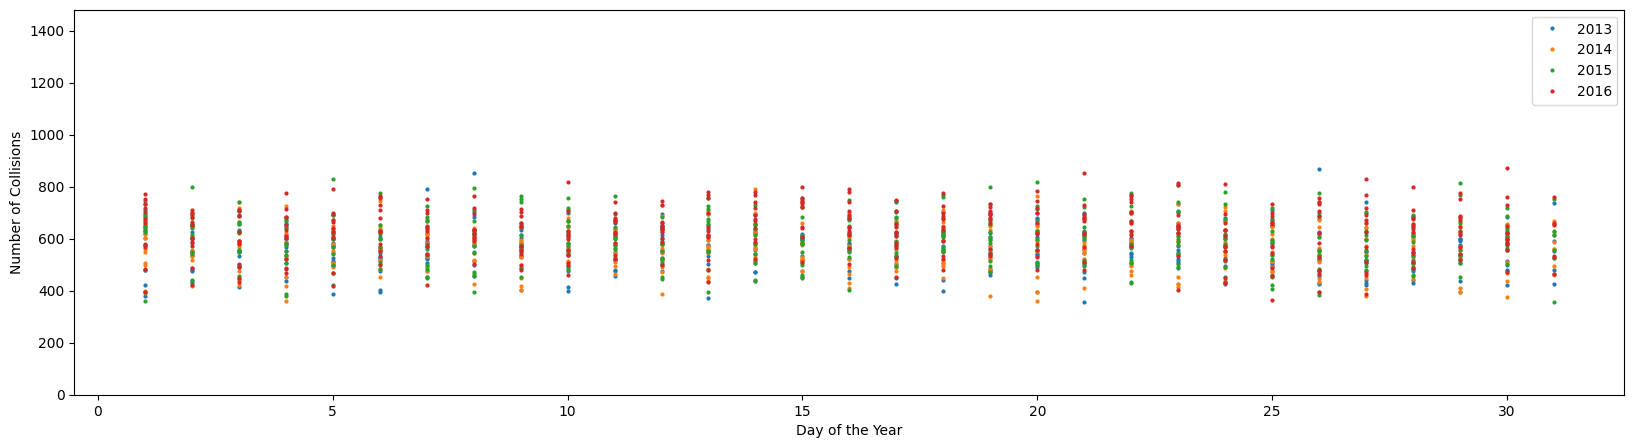

In [99]:
# check out this plot
groups = df_final.groupby('year') # We group by year as we want to create a legend and make the visualization clearer using color.
plt.ylim(0, 1480)

for name, group in groups:
    plt.plot(group.da, group.NUM_COLLISIONS, marker='o', linestyle='', markersize=2, label=name)

plt.legend()

# Adding axis titles
plt.xlabel('Day of the Year')
plt.ylabel('Number of Collisions')

plt.show()

Regression model

In [ ]:
import tensorflow as tf
import keras
from tensorflow import keras
from tensorflow.keras import layers
from keras import layers
from tensorflow.python.keras.layers import Dense
print(tf.__version__)



In [ ]:
#very simple model, with just one single input (days) and one output (NUM_COLLISIONS).

one_input_data = [df_final["day"], df_final["NUM_COLLISIONS"]] # create an array of all values for day and all values for NUM_TRIPS in two columns
headers = ["day", "NUM_COLLISIONS"] # declare the titles of our input and output. As you can see day is first and NUM_TRIPS is second and they correspond to the line above
df_one_input = pd.concat(one_input_data, axis=1, keys=headers) # Bring these two arrays together to make a new dataframe
df_one_input.head()

In [66]:
 #ok now to train model
 #This code is performing a common task in data science: splitting a dataset into training and test sets. 

train_dataset = df_one_input.sample(frac=0.8, random_state=0)
test_dataset = df_one_input.drop(train_dataset.index)



In [ ]:
train_dataset.describe()

In [68]:
#test_dataset.describe()

In [69]:
#train_features = train_dataset.copy(): Creates a copy of the train_dataset DataFrame and stores it in train_features.
#test_features = test_dataset.copy(): Similarly, creates a copy of the test_dataset DataFrame and stores it in test_features.
#Why .copy()?: The .copy() method is used to ensure that the original train_dataset and test_dataset are not modified when changes are made to train_features and test_features.

train_features = train_dataset.copy()
test_features = test_dataset.copy()

#The labels (train_labels and test_labels) represent the actual number of collisions in each row of your dataset. 
# The model will use other features (input variables) to try and predict this value. 

train_labels = train_features.pop('NUM_COLLISIONS')
test_labels = test_features.pop('NUM_COLLISIONS')



In [ ]:
print(train_features.head())
print(test_features.head())

In [71]:
scale_factor = 1000000

In [ ]:
train_labels = train_labels/scale_factor
test_labels = test_labels/scale_factor
print(train_labels)

##train_labels = train_labels / scale_factor: This line divides each element in the train_labels Series by the scale_factor (which is set to 1,000,000). 
# This effectively scales down the values of the labels in the training dataset, making them smaller and potentially easier to work with.
#test_labels = test_labels / scale_factor: 
# Similarly, this line divides each element in the test_labels Series by the same scale_factor, scaling down the labels in the testing dataset.

In [ ]:
import tensorflow as tf
import numpy as np

# Assuming train_features is your training data

#tf.keras.layers.Normalization: This creates a normalization layer that will standardize the features (input data).
#axis=-1: This indicates that normalization will be applied across the last axis. 
# For example, if you have a 2D array (matrix), normalization will be applied to each row independently.

normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))

first = np.array(train_features[:1])

# Print the first example before and after normalization
with np.printoptions(precision=2, suppress=True):
    print('First example:', first)
    print()
    print('Normalized:', normalizer(first).numpy())


In [ ]:
import tensorflow as tf
import numpy as np

# Assuming train_features is your DataFrame and 'day' is one of its columns
day = np.array(train_features['day'])

# train_features['day']: This selects the column labeled 'day' from the train_features DataFrame. 
# It assumes that train_features is a pandas DataFrame containing various features.

# tf.keras.layers.Normalization: This creates a normalization layer specifically for the day feature.
#input_shape=[1,]: This indicates that the input to the layer will be a 1D array with one element (the day value).
#axis=None: This means that normalization will be applied to the entire input (single value), rather than along a specific axis.

# Define and adapt the Normalization layer
day_normalizer = tf.keras.layers.Normalization(input_shape=[1,], axis=None)
day_normalizer.adapt(day)


In [ ]:
import tensorflow as tf
import numpy as np

# This creates a sequential model, which is a linear stack of layers. 
# You can think of it as a chain where the output of one layer is the input to the next.

# Assuming day_normalizer is already defined as in your previous code
# Define the model
day_model = tf.keras.Sequential([
    day_normalizer,
    tf.keras.layers.Dense(units=1)  # accessing Dense layer through tf.keras.layers
])

# : This adds a Dense layer with a single unit (or neuron). 
# A Dense layer is a fully connected layer where each input node is connected to each output node. 
# The output will be a single value, which might represent a prediction (for example, predicting a target variable based on the normalized day).

# Print model summary
day_model.summary()



In [ ]:
day_model.predict(day[:10])

In [ ]:
day_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

print("It worked")

Keras model - exec training for 100 epochs

In [ ]:
%%time
history = day_model.fit(
    train_features['day'],
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

In [80]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 0.2])
  plt.xlabel('Epoch')
  plt.ylabel('Error [NUM_TRIPS]')
  plt.legend()
  plt.grid(True)

In [ ]:
plot_loss(history)

In [82]:
test_results = {}

test_results['day_model'] = day_model.evaluate(
    test_features['day'],
    test_labels, verbose=0)

In [ ]:
x = tf.linspace(1, 7, 8)
y = day_model.predict(x)

In [ ]:
#sense check
print("Unique days:", train_features['day'].unique())
print("Number of trips:", train_labels.shape)


In [ ]:
print("Predicted days:", x[:10])
print("Predicted NUM_TRIPS:", y[:10])


In [ ]:
plt.boxplot(train_labels)  # Boxplot to check for outliers
plt.show()


(8,)
(8, 1)


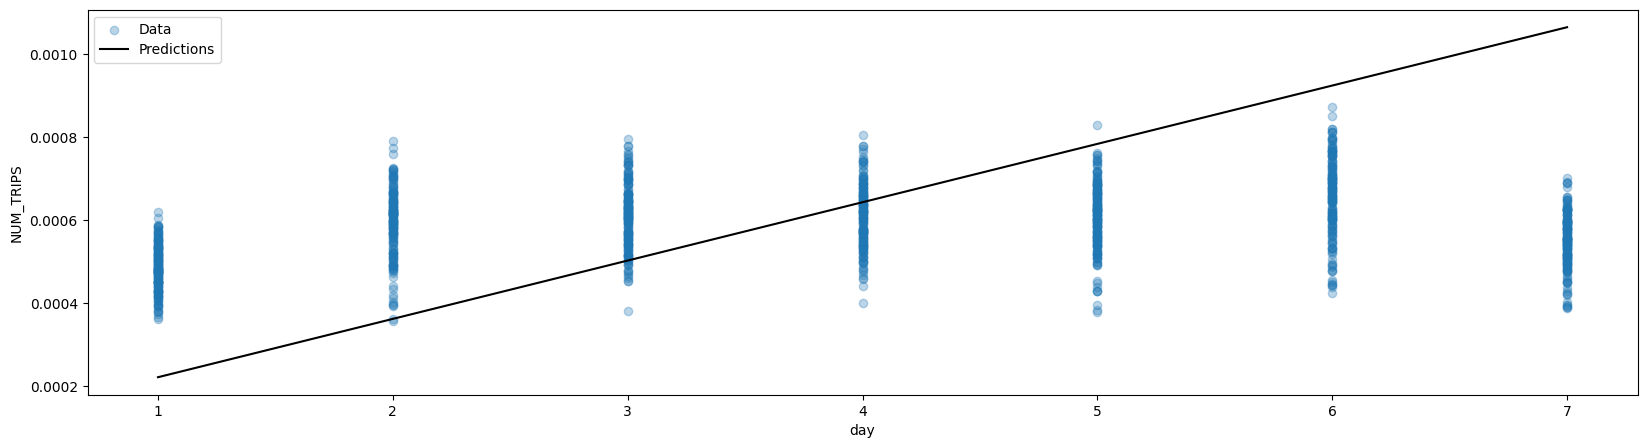

In [96]:
def plot_day(x, y):
  plt.scatter(train_features['day'], train_labels, label='Data', alpha=0.3)
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('day')
  plt.ylim([0.2, 0.8])
  plt.ylabel('NUM_TRIPS')
  plt.legend()

print(x.shape)
print(y.shape)

plot_day(x, y)